# Glycolytic Oscillation in Yeast

Glycolysis is a process by which a glucose molecule is broken down into smaller molecules in both prokaryotes and eukaryotes. One of its primary roles is producing adenosine triphosphate (ATP) under conditions where respiration is absent. Glycolytic oscillations may appear in cell-free extracts or dense suspensions of non-growing cells of yeast *Saccharomyces cerevisiae* under starvation. The oscillations are primarily driven by the interaction of adenosine diphosphate (ADP) and ATP. This interaction serves as a basis for the popular Selkov model of glycolytic oscillations. The following form of the Selkov model has been used:

$$
\begin{align}
    \frac{dx}{dt} &= a +  x^2 y - x, \\
    \frac{dy}{dt} &= b - x^2 y.
\end{align}
$$

where $ x$ and $ y $ are dimensionless variables that may represent ADP and ATP concentration, respectively.

## Parameters
- $ a = 0.1 $
- $b = 0.2 $


In [1]:
import sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)


3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/tiseanpy/bin/python
____________________________________________________________


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/4_Chapter_4_PyTISEAN


In [3]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots_5")
os.makedirs(plot_dir, exist_ok=True) 

In [4]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 

In [5]:
import tempfile
import pytisean.pytisean
# point pytisean’s temp‐dir to whatever tempfile.gettempdir() returns
pytisean.pytisean.DIRSTR = tempfile.gettempdir()
from pytisean import tiseano, tiseanio

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black

In [7]:
# Define the Glycolytic Oscillation Model
def glycolytic_oscillations(state,t, a=0.1, b=0.2):
    x, y = state  
    dx_dt = a + x**2 *y - x
    dy_dt = b - x**2 *y 
    return [dx_dt, dy_dt]


In [8]:
# Parameters for ODE Integrator
t_max = 100  # Maximum time for the simulation
dt = 0.001  # The time step
t_train = np.arange(0, t_max, dt) # Time points for simulation
X0 = [0, 0]  # Initial state of the system

# Solve the system of ODEs
X = odeint(glycolytic_oscillations, X0, t_train, args=(0.1, 0.2))


In [9]:
# Print sizes of t_train, X 
print("Size of t_train:", t_train.shape)
print("Size of X:", X.shape)

Size of t_train: (100000,)
Size of X: (100000, 2)


In [10]:
x_t = X[:,0] # Choose x(t), a scaler time series

In [11]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 100000


## Time Delay

In [12]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', '/tmp/pytisean_temp_2025-07-07-14-42-11_rimhr3ms.dat', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-42-11_l0mvjalt.dat']



(100000, 2)

In [13]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


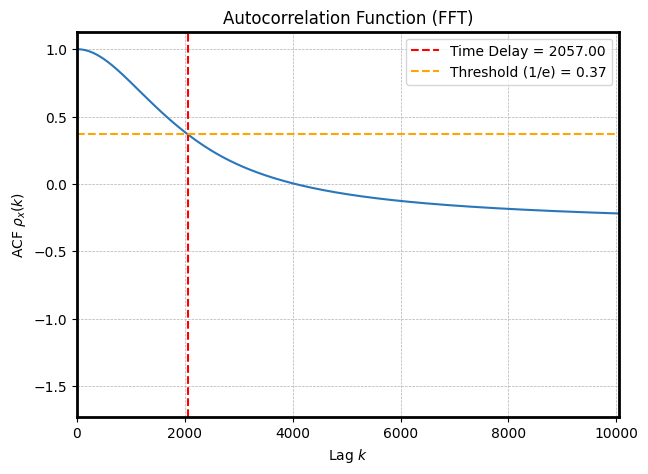

Selected  delay: 2057.0


In [14]:
# Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$',)
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)


# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 8000) 
plt.savefig("Plots_5/TimeDelay_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()

print(f"Selected  delay: {time_delay_value}")


## Embedding Dimesion

['false_nearest', '/tmp/pytisean_temp_2025-07-07-14-42-19_6l2qzhf3.dat', '-m', '1', '-M', '1,6', '-d', '2057', '-f', '3', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-42-19_3_lzbsvs.dat']



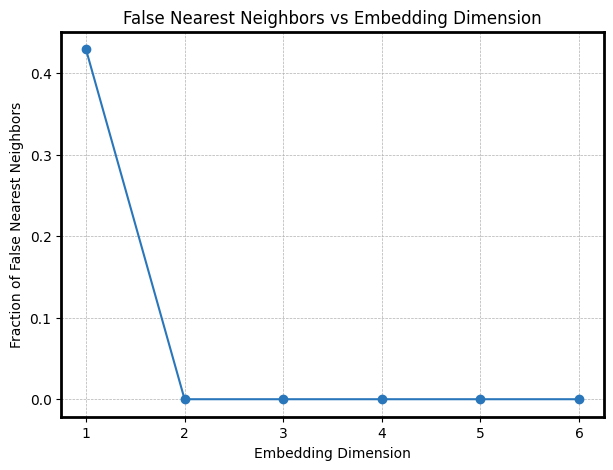

In [15]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,6', '-d', 2057, '-f',3, '-V',0, data=x_t)
# Plot the fraction of false nearest neighbors against embedding dimension
embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_5/Embedding_Dimension_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()


In [16]:
fnn_values

array([0.4290652, 0.       , 0.       , 0.       , 0.       , 0.       ])

In [17]:
## Time Delay = 2057
## Embedding Dimension = 2

In [18]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 2, '-d', 2057, '-V', 0, data=x_t)

['delay', '/tmp/pytisean_temp_2025-07-07-14-42-26_nzpp2a7l.dat', '-m', '2', '-d', '2057', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-42-26_qr4d4sdw.dat']



In [19]:
delay_information

array([[8.868664e-02, 0.000000e+00],
       [8.870116e-02, 9.995003e-05],
       [8.871568e-02, 1.998002e-04],
       ...,
       [3.943217e-01, 1.519704e+00],
       [3.940794e-01, 1.519064e+00],
       [3.938373e-01, 1.518423e+00]])

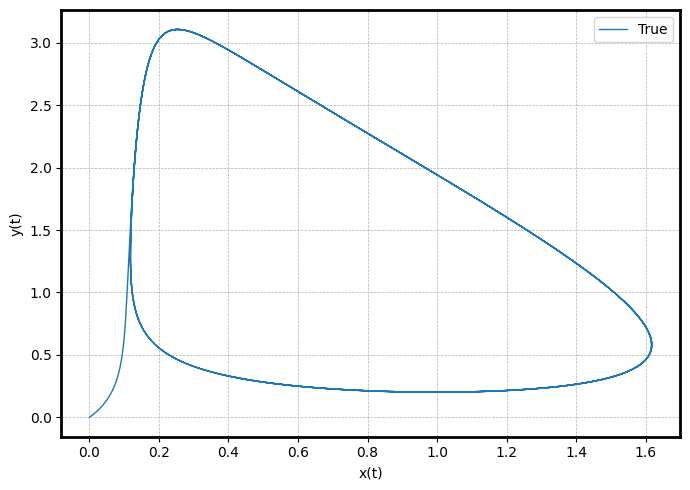

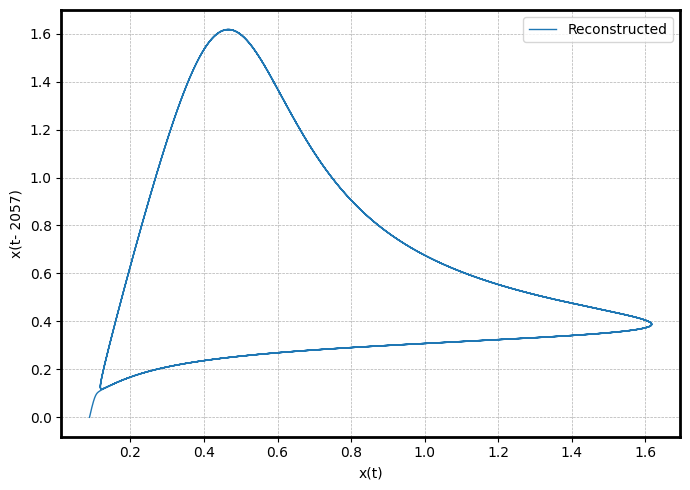

In [20]:
# Phase Digram
# True phase space 
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(X[:, 0], X[:, 1],lw=1.0, label='True')
ax1.set(xlabel='x(t)', ylabel='y(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
ax1.legend(loc='best')
set_spines_black(ax1)     
fig1.tight_layout()
plt.savefig("Plots_5/True_phase_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()


# Reconstructed phase space: [x(t), x(t - tau)]
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(delay_information[:, 0], delay_information[:, 1],lw=1.0,label='Reconstructed')
ax2.set(xlabel='x(t)', ylabel='x(t- 2057)')
ax2.grid(True, which='both', ls='--', lw=0.5)
ax2.legend(loc='best')
set_spines_black(ax2)     
fig2.tight_layout()
plt.savefig("Plots_5/Reconstructed_phase_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()



In [21]:
# Extracting the Latent Features

In [22]:
# Perform SVD 
U, S, Vt = np.linalg.svd(delay_information,  full_matrices = False)

In [23]:
print(U)

[[-0.00036948 -0.00075119]
 [-0.00036993 -0.0007504 ]
 [-0.00037038 -0.00074962]
 ...
 [-0.00754631  0.01046493]
 [-0.00754281  0.01046117]
 [-0.00753931  0.0104574 ]]


In [24]:
print("Shape of embedded data:", delay_information.shape)
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of Vt:", Vt.shape)


Shape of embedded data: (97943, 2)
Shape of U: (97943, 2)
Shape of S: (2,)
Shape of Vt: (2, 2)


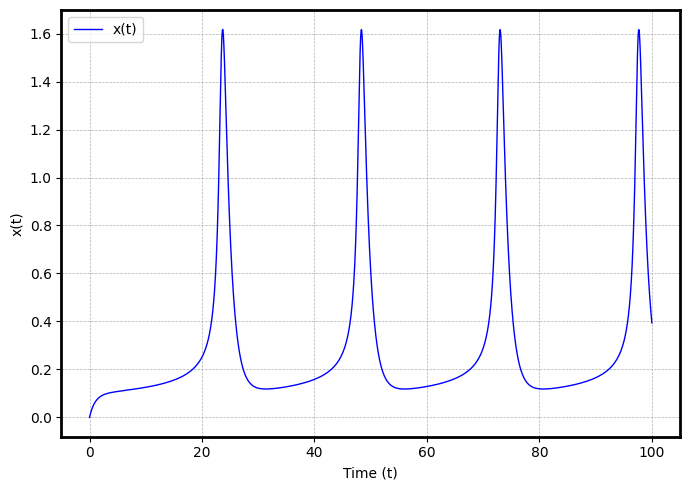

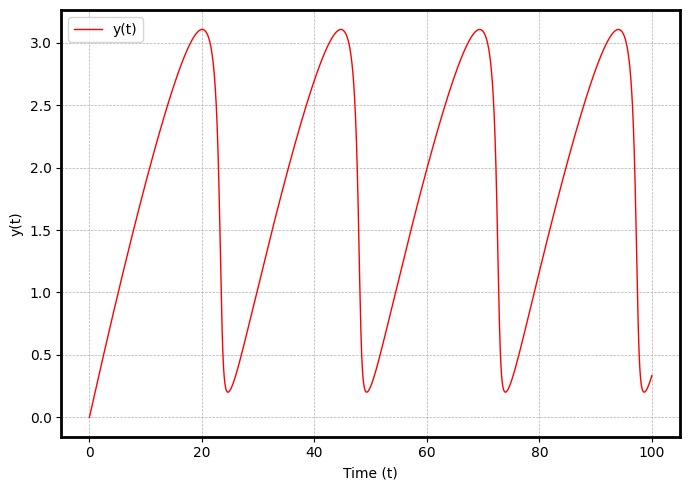

In [25]:
# Plot the original time series obtained corresponding to each variable
# First variable x(t)
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(t_train, X[:, 0], color='b', lw=1.0, label='x(t)')
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.show()


# Second variable y(t)
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(t_train, X[:, 1], color='r', lw=1.0, label='y(t)')
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.show()


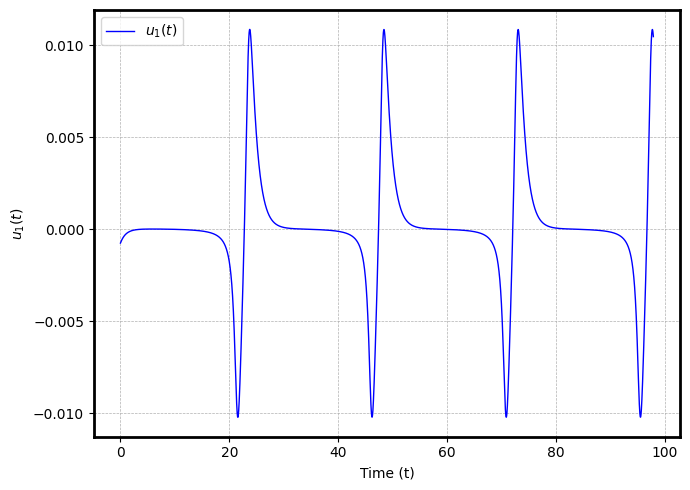

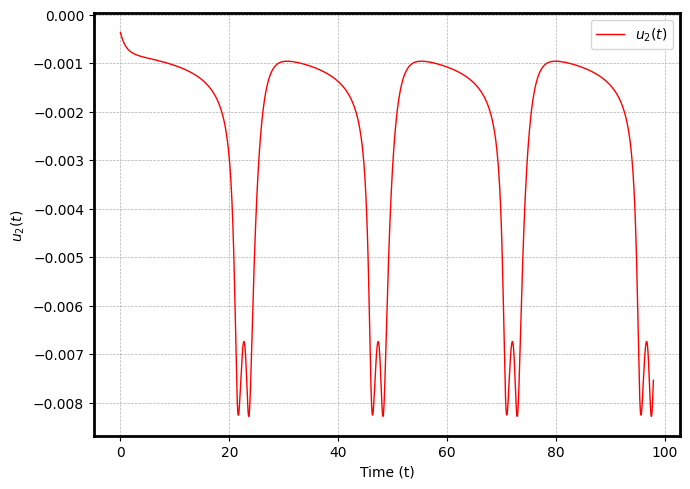

In [26]:
# Plot the time series obtained using SVD
min_len = min(len(t_train), len(U[:, 0]))
# First variable 
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(t_train[:min_len], U[:, 1], color='b', lw=1.0, label='$u_1(t)$')
ax2.set(xlabel='Time (t)', ylabel='$u_1(t)$')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.savefig("Plots_5/Latent_u1_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()

# Second variable 
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(t_train[:min_len], U[:, 0], color='r', lw=1.0, label='$u_2(t)$')
ax1.set(xlabel='Time (t)', ylabel='$u_2(t)$')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.savefig("Plots_5/Latent_u2_Glycolytic_Oscillation_model.pdf", bbox_inches="tight")
plt.show()


#############################################################################################################################